<b> <font size="+2.5"> Descriptive statistics (Controls vs Cases)
 </b> </font> <br>

Date: 2023-12-27 <br>
Author: ASF

# Load libraries

In [1]:
suppressPackageStartupMessages({
library(tidyverse)
library(readxl)
library(ggplot2)
library(cowplot)
library(ggpubr)
library(car)
library(rstatix)
library(lawstat)
})

# read in meta_data from single nuclei RNA-seq (adata obs)

In [2]:
scanpy_counts_metrics <- read.delim("../datasets/adata.obs_20231120.tsv", sep='\t')

# select meta_data of interest
meta_data <- scanpy_counts_metrics
meta_data <- meta_data %>% select(c('individual', 'Status', 'Classification', 'Sex', 'Age', 'AgeBin','Brain.pH', 'RIN', 'PMI', 'X6.Batch')) %>% distinct()
meta_data <- as.data.frame(meta_data)

# format meta data
meta_data$individual <- as.character(meta_data$individual)

meta_data$RIN[is.na(meta_data$RIN)] = median(meta_data$RIN, na.rm=TRUE) 

meta_data$Status <- as.factor(as.character(meta_data$Status))
meta_data$Status <- factor(meta_data$Status, c('0','1'))
meta_data$Disease_Status <- ifelse(meta_data$Status=='0', 'Controls', 'Cases')
meta_data$Disease_Status <- factor(meta_data$Disease_Status, levels=c('Controls', 'Cases'))

meta_data$X6.Batch <- as.character(meta_data$X6.Batch)
colnames(meta_data)[which(names(meta_data) == 'X6.Batch')] <- 'lib_batch'

colnames(meta_data)[which(names(meta_data) == 'Brain.pH')] <- 'pH'

# Summarise the data

In [3]:
median_genes_per_nucleus <- scanpy_counts_metrics %>%
  group_by(SU.Number) %>%
  summarise(median_n_genes = median(n_genes), n_nuclei = n())
median_genes_per_nucleus <- as.data.frame(median_genes_per_nucleus)

median_counts_per_nucleus <- scanpy_counts_metrics %>%
  group_by(SU.Number) %>%
  summarise(median_n_counts = median(n_counts))
median_counts_per_nucleus <- as.data.frame(median_counts_per_nucleus)

metrics <- merge(median_genes_per_nucleus, median_counts_per_nucleus, by='SU.Number')
colnames(metrics)[1] <- 'individual'
meta_data_w_metrics <- merge(meta_data, metrics, by='individual')

In [4]:
scanpy_counts_metrics %>%
  summarise(median_n_counts = median(n_counts))

scanpy_counts_metrics %>%
  summarise(median_n_genes = median(n_genes))

median_n_counts
<dbl>
3900


median_n_genes
<int>
2210


# Extended Data Figure1 

## Extended Data Figure 1a - Age & Sex & Disease distribution

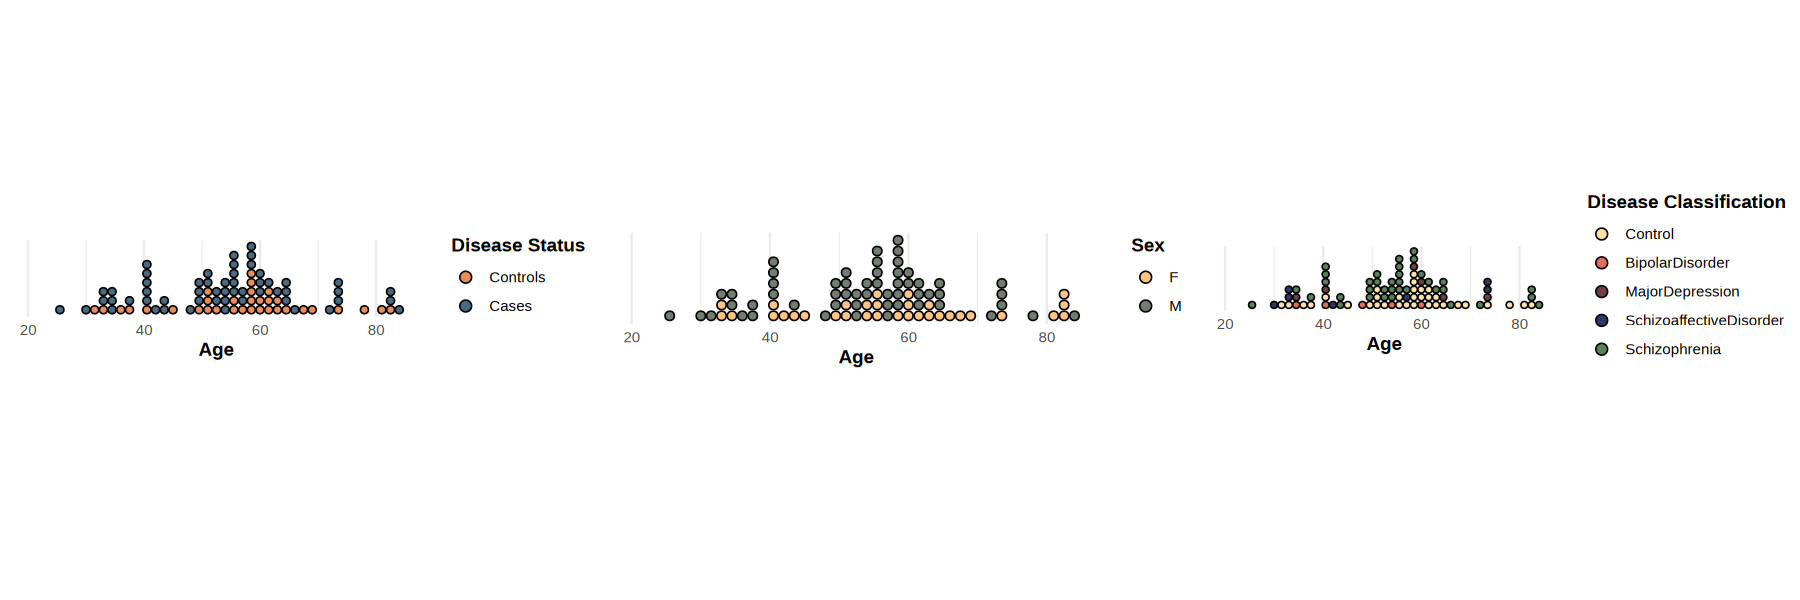

In [5]:
histodot_list <- list()
histodot_list[['Age']] <- ggplot(meta_data_w_metrics, aes(Age, fill=factor(Disease_Status))) + theme_minimal() +
  geom_dotplot(method = 'histodot', binwidth = 1.5, dotsize = 0.8, stackratio = 1.3, stackgroups=T) +
  scale_y_continuous(NULL, breaks = NULL) +
  # Make this as high as the tallest column
  coord_fixed(ratio = 12) + xlim(20, 85) + scale_fill_manual(values=c("#EA8C55", "#496A81"), 
                                                             name="Disease Status") +
  theme(axis.title = element_text(face="bold"), legend.title = element_text(face = "bold"))

histodot_list[['Sex']] <- ggplot(meta_data_w_metrics, aes(Age, fill=factor(Sex))) + theme_minimal() +
  geom_dotplot(method = 'histodot', binwidth = 1.5, dotsize = 0.8, stackratio = 1.3, stackgroups=T) +
  scale_y_continuous(NULL, breaks = NULL) +
  # Make this as high as the tallest column
  coord_fixed(ratio = 12) + xlim(20, 85) + scale_fill_manual(values=c("#FFC482", "#727D71"), 
                                                             name="Sex",
                                                             breaks=c("Female", "Male"),
                                                             labels=c('F', 'M')) +
  theme(axis.title = element_text(face="bold"), legend.title = element_text(face = "bold"))

histodot_list[['Disease_Classification']] <- ggplot(meta_data_w_metrics, aes(Age, fill=factor(Classification))) + theme_minimal() +
  geom_dotplot(method = 'histodot', binwidth = 1.5, dotsize = 0.8, stackratio = 1.3, stackgroups=T) +
  scale_y_continuous(NULL, breaks = NULL) +
  # Make this as high as the tallest column
  coord_fixed(ratio = 12) + xlim(20, 85) + scale_fill_manual(values=c("#FFE1A8","#E26D5C","#723D46", "#2B3A67","#588157"), 
                                                             name="Disease Classification", 
                                                             breaks=c("Control", "BipolarDisorder", 'MajorDepression',
                                                                     'SchizoaffectiveDisorder', 'Schizophrenia')) +
  theme(axis.title = element_text(face="bold"), legend.title = element_text(face = "bold"))

options(repr.plot.width=15, repr.plot.height=5)
plot_grid(plotlist=histodot_list, nrow=1)
ggsave('../results/cohort_descrip/figures/histodot_cohort_Age_Status_Sex_Classification.pdf', plot=last_plot(), width=16, height=5)

## Extended Data Figure 1b - Box plots for variables of interest

In [6]:
# split data set into cases and controls
Ctrls <- meta_data_w_metrics[meta_data_w_metrics$Status=='0', ]
Cases <- meta_data_w_metrics[meta_data_w_metrics$Status=='1', ]

# test for normality
shapiro.test(Ctrls$Age)$p.value 
shapiro.test(Cases$Age)$p.value 
shapiro.test(Ctrls$PMI)$p.value 
shapiro.test(Cases$PMI)$p.value # NOT normally distributed
shapiro.test(Ctrls$RIN)$p.value # NOT normally distributed
shapiro.test(Cases$RIN)$p.value # NOT normally distributed
shapiro.test(Ctrls$pH)$p.value 
shapiro.test(Cases$pH)$p.value 
shapiro.test(Ctrls$median_n_genes)$p.value 
shapiro.test(Cases$median_n_genes)$p.value 
shapiro.test(Ctrls$median_n_counts)$p.value 
shapiro.test(Cases$median_n_counts)$p.value # NOT normally distributed

[1] 0.23184

[1] 0.3411401

[1] 0.2732361

[1] 0.01532164

[1] 0.0001395119

[1] 0.03147479

[1] 0.05428265

[1] 0.6467507

[1] 0.4213362

[1] 0.1385235

[1] 0.2310093

[1] 0.02738216

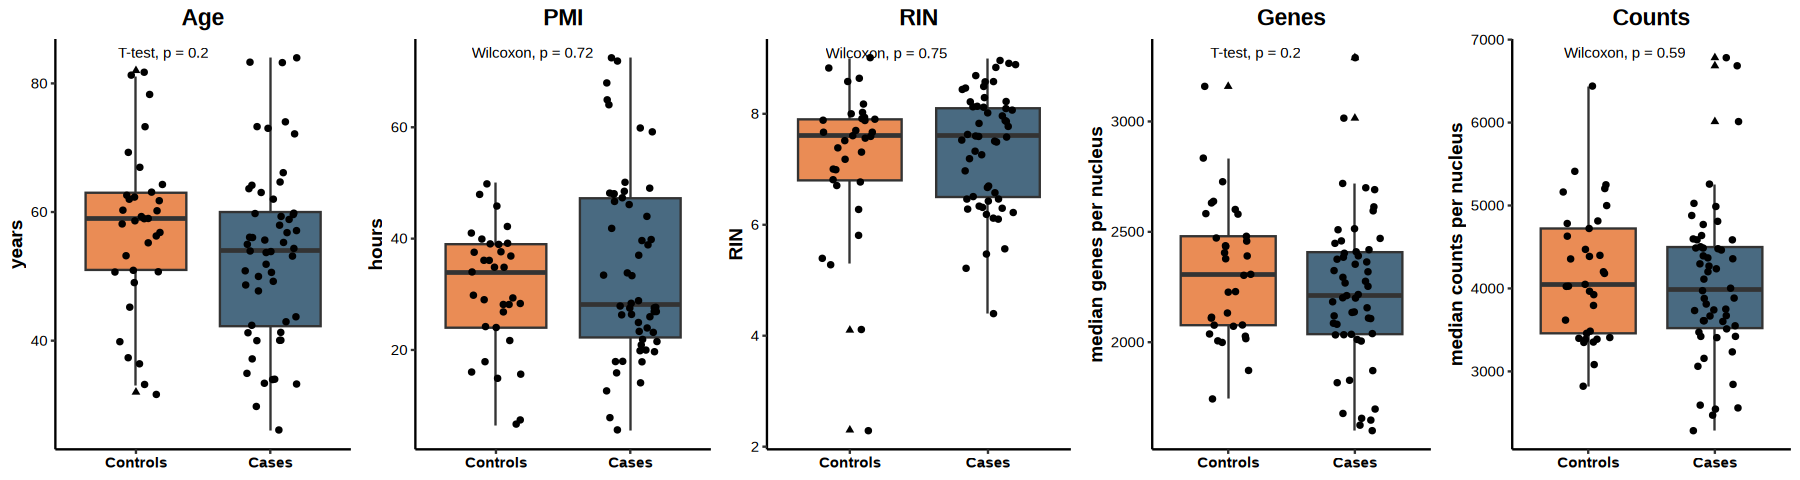

In [7]:
figList <- list()

figList[['Age']] <- ggplot(meta_data_w_metrics, aes(x=Disease_Status, y=Age, fill=Disease_Status)) + 
  geom_boxplot(outlier.color="black", outlier.shape=17) + geom_jitter(shape=16, colour='black', position=position_jitter(0.2)) +
theme_classic() + theme(legend.position = 'none')+ ylab('years') + xlab('Disease Status') + 
stat_compare_means(method = "t.test", size=3) +
theme(axis.title=element_text(face='bold'),axis.text = element_text(colour="black"), 
      axis.text.x = element_text(face="bold"), 
axis.title.x = element_blank(), plot.title = element_text(hjust = 0.5, face='bold')) + 
ggtitle('Age') +scale_fill_manual(values=c("#EA8C55", "#496A81"))

figList[['PMI']] <- ggplot(meta_data_w_metrics, aes(x=Disease_Status, y=PMI, fill=Disease_Status)) + 
  geom_boxplot(outlier.color="black", outlier.shape=17) + geom_jitter(shape=16, colour='black', position=position_jitter(0.2)) +
theme_classic() + theme(legend.position = 'none')+ ylab('hours') + xlab('Disease Status') + 
stat_compare_means(method = "wilcox.test", size=3) +
theme(axis.title=element_text(face='bold'),axis.text = element_text(colour="black"), 
      axis.text.x = element_text(face="bold"), 
axis.title.x = element_blank(), plot.title = element_text(hjust = 0.5, face='bold')) + 
ggtitle('PMI') +scale_fill_manual(values=c("#EA8C55", "#496A81"))

figList[['RIN']] <- ggplot(meta_data_w_metrics, aes(x=Disease_Status, y=RIN, fill=Disease_Status)) + 
  geom_boxplot(outlier.color="black", outlier.shape=17) + geom_jitter(shape=16, colour='black', position=position_jitter(0.2)) +
theme_classic() + theme(legend.position = 'none')+ ylab('RIN') + xlab('Disease Status') + 
stat_compare_means(method = "wilcox.test", size=3) +
theme(axis.title=element_text(face='bold'),axis.text = element_text(colour="black"), 
      axis.text.x = element_text(face="bold"), 
axis.title.x = element_blank(), plot.title = element_text(hjust = 0.5, face='bold')) + 
ggtitle('RIN') +scale_fill_manual(values=c("#EA8C55", "#496A81"))

figList[['Genes']] <- ggplot(meta_data_w_metrics, aes(x=Disease_Status, y=median_n_genes, fill=Disease_Status)) + 
  geom_boxplot(outlier.color="black", outlier.shape=17) + geom_jitter(shape=16, colour='black', position=position_jitter(0.2)) +
theme_classic() + theme(legend.position = 'none')+ ylab('median genes per nucleus') + xlab('Disease Status') + 
stat_compare_means(method = "t.test", size=3) +
theme(axis.title=element_text(face='bold'),axis.text = element_text(colour="black"), 
      axis.text.x = element_text(face="bold"), 
axis.title.x = element_blank(), plot.title = element_text(hjust = 0.5, face='bold')) + 
ggtitle('Genes') +scale_fill_manual(values=c("#EA8C55", "#496A81"))

figList[['Counts']] <- ggplot(meta_data_w_metrics, aes(x=Disease_Status, y=median_n_counts, fill=Disease_Status)) + 
  geom_boxplot(outlier.color="black", outlier.shape=17) + geom_jitter(shape=16, colour='black', position=position_jitter(0.2)) +
theme_classic() + theme(legend.position = 'none')+ ylab('median counts per nucleus') + xlab('Disease Status') + 
stat_compare_means(method = "wilcox.test", size=3) +
theme(axis.title=element_text(face='bold'),axis.text = element_text(colour="black"), 
      axis.text.x = element_text(face="bold"), 
axis.title.x = element_blank(), plot.title = element_text(hjust = 0.5, face='bold')) + 
ggtitle('Counts') +scale_fill_manual(values=c("#EA8C55", "#496A81"))

options(repr.plot.width=15, repr.plot.height=4)
plot_grid(plotlist=figList, nrow=1)

#ggsave('../results/cohort_descrip/figures/boxplot_Age_PMI_RIN_Genes_Counts.pdf', plot=last_plot(), width=12, height=4)

## Extended Data Figure 1c - Scatterplots for variables of interest

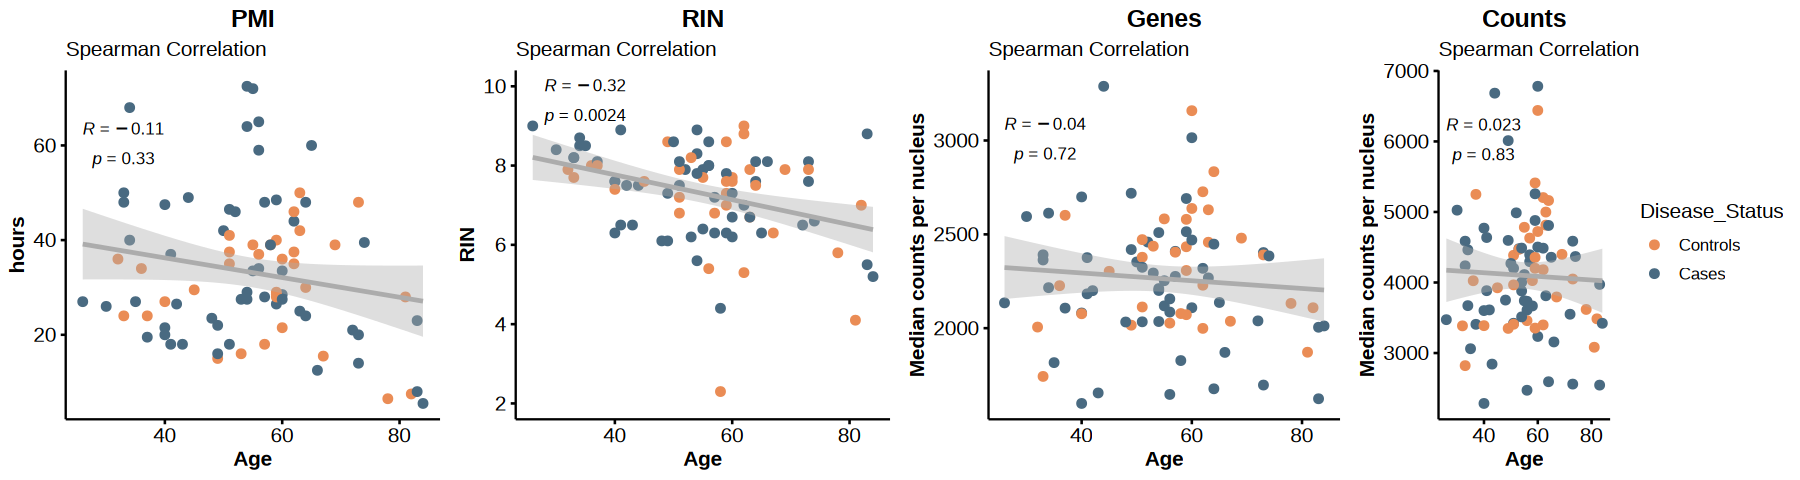

In [8]:
figList2<- list()

# PMI
figList2[['PMI']] <- ggscatter(meta_data_w_metrics, x='Age', y='PMI', color='Disease_Status', title='PMI', 
          xlab='Age', ylab='hours', palette = c("#EA8C55", "#496A81"), add = "reg.line", 
          conf.int = TRUE, subtitle = "Spearman Correlation",cor.coef = TRUE, legend='right', 
          cor.method = "spearman", add.params = list(color = "#acacac", fill = "#acacac"),
          cor.coeff.args = list(label.y = 60, label.sep = "\n", size=3.5) ) + 
theme(axis.title = element_text(face="bold"), legend.position = 'none') + 
theme(plot.title = element_text(hjust = 0.5, face='bold'))


# RIN
figList2[['RIN']] <- ggscatter(meta_data_w_metrics, x='Age', y='RIN', color='Disease_Status', title='RIN', 
          xlab='Age', palette = c("#EA8C55", "#496A81"), add = "reg.line", 
          conf.int = TRUE, subtitle = "Spearman Correlation",cor.coef = TRUE, legend='right', 
          cor.method = "spearman", add.params = list(color = "#acacac", fill = "#acacac"),
          cor.coeff.args = list(label.y = 9.6, label.x = 28, label.sep = "\n", size=3.5 )) + 
theme(axis.title = element_text(face="bold"), legend.position = 'none') + 
theme( plot.title = element_text(hjust = 0.5, face='bold')) + ylim(2,10)


#median n genes
figList2[['Genes']] <- ggscatter(meta_data_w_metrics, x='Age', y='median_n_genes', color='Disease_Status', title='Genes', 
          xlab='Age', ylab='Median counts per nucleus', palette = c("#EA8C55", "#496A81"), add = "reg.line", 
          conf.int = TRUE, subtitle = "Spearman Correlation",cor.coef = TRUE, legend='right', 
          cor.method = "spearman", add.params = list(color = "#acacac", fill = "#acacac"),
          cor.coeff.args = list(label.y = 3000, label.sep = "\n", size=3.5) ) + 
theme(axis.title = element_text(face="bold"), legend.position = 'none') + 
theme( plot.title = element_text(hjust = 0.5, face='bold'))

# median_n_counts
options(repr.plot.width = 3, repr.plot.height =3)
figList2[['Counts']] <- ggscatter(meta_data_w_metrics, x='Age', y='median_n_counts', color='Disease_Status', title='Counts', 
          xlab='Age', ylab='Median counts per nucleus', palette = c("#EA8C55", "#496A81"), add = "reg.line", 
          conf.int = TRUE, subtitle = "Spearman Correlation",cor.coef = TRUE, legend='right', 
          cor.method = "spearman", add.params = list(color = "#acacac", fill = "#acacac"),
          cor.coeff.args = list(label.y = 6000, label.sep = "\n", size=3.5) ) + 
theme(axis.title = element_text(face="bold"), legend.position = 'right') + 
theme( plot.title = element_text(hjust = 0.5, face='bold')) 

options(repr.plot.width=15, repr.plot.height=4)
plot_grid(plotlist=figList2, nrow=1)
#ggsave('../results/cohort_descrip/figures/Spearman_cor_Age_with_PMI_RIN_Genes_Counts.pdf', plot=last_plot(), width=12, height=4)

In [8]:
ggsave('../results/cohort_descrip/figures/Spearman_cor_Age_with_PMI.pdf', plot=figList2[['PMI']], width=2.7, height=3.6)
ggsave('../results/cohort_descrip/figures/Spearman_cor_Age_with_RIN.pdf', plot=figList2[['RIN']], width=2.7, height=3.6)
ggsave('../results/cohort_descrip/figures/Spearman_cor_Age_with_Genes.pdf', plot=figList2[['Genes']], width=2.7, height=3.6)
ggsave('../results/cohort_descrip/figures/Spearman_cor_Age_with_Counts.pdf', plot=figList2[['Counts']], width=4.4, height=3.6)

# Extended Data Figure 2

## Extended Data Figure 2b

In [9]:
# read in nuclei counts
nuclei_counts_per_individual <- read_excel("../datasets/nuclei_counts_per_individual_20231121.xlsx")

In [10]:
nuclei_counts_w_meta_data <- merge(meta_data, nuclei_counts_per_individual, by='individual')

In [11]:
# per batch 
nuclei_counts_w_meta_data$lib_batch <- as.numeric(nuclei_counts_w_meta_data$lib_batch)
nuclei_per_celltype_batch_strat <- as.data.frame(matrix(ncol=4, nrow=0))
colnames(nuclei_per_celltype_batch_strat) <- c('Library preparation batch', 'nuclei count', 'celltype', 'Percentage')
for (celltype in colnames(nuclei_counts_per_individual)[2:22]){
  tmp <- nuclei_counts_w_meta_data[,names(nuclei_counts_w_meta_data) %in% c(celltype, 'lib_batch')]
  df <- as.data.frame(aggregate(tmp[1], by=list(Lib_batch=tmp$lib_batch), FUN=sum, na.rm=TRUE))
  colnames(df) <- c('Library preparation batch', 'nuclei count')
  df$celltype <- celltype
  df$Percentage <- df$`nuclei count`/sum(df$`nuclei count`)*100
  nuclei_per_celltype_batch_strat <- rbind(nuclei_per_celltype_batch_strat, df)
}

nuclei_per_celltype_batch_strat$`Library preparation batch` <- as.character(nuclei_per_celltype_batch_strat$`Library preparation batch`)
nuclei_per_celltype_batch_strat$`Library preparation batch` <- factor(nuclei_per_celltype_batch_strat$`Library preparation batch`, levels=c('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16' ))

In [12]:
nuclei_per_celltype_batch_strat$celltype <- factor(nuclei_per_celltype_batch_strat$celltype, levels=c( "OPC", "Oligodendrocyte", "Microglia", "In_VIP", "In_SST", "In_RELN", "In_PVALB_Ch", "In_PVALB_Ba", "In_LAMP5_2", "In_LAMP5_1", "Exc_L5-6_HTR2C", "Exc_L5-6_2", "Exc_L5-6_1", "Exc_L4-6_3", "Exc_L4-6_2", "Exc_L4-6_1",  "Exc_L3-5", "Exc_L2-3","Endothelial","Astro_PP","Astro_FB" ))

barplot_list <- list()
barplot_list[['batch']] <- ggplot(data=nuclei_per_celltype_batch_strat, aes(x=celltype, y=Percentage, fill=`Library preparation batch`)) + 
  geom_bar(position = 'stack', stat='identity') + xlab('Cell Type') +ylab('Percentage') +
  coord_flip() + 
scale_fill_manual(values = c("#DDC9B4", "#FFE1A8", "#FFC482", '#EA8C55', "#7A6C5D", "#6e4c3c", "#2B3A67",
                             "#2A3D45", "#588157", "#A3B18A", "#66999B", "#727D71", "#472D30", "#723D46", 
                             "#C17C74", "#E26D5C"), breaks =c('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 
                                                              '11', '12', '13', '14', '15', '16' ) )+ ylim(0,100) +
ggtitle('% of nuclei per batch') + theme_classic() + theme(axis.text=element_text(size=10, color = 'black'),  
                                                           axis.title=element_text(size=12,face="bold"), 
                                                           plot.title = element_text(size=16, face='bold')) + 
labs(fill='Library\npreparation\nbatch')

In [13]:
# per disease status
Controls <- nuclei_counts_w_meta_data[nuclei_counts_w_meta_data$Status =='0',]
Cases <- nuclei_counts_w_meta_data[nuclei_counts_w_meta_data$Status =='1',]

nuclei_per_celltype_status_strat <- as.data.frame(matrix(ncol=5, nrow=0))
colnames(nuclei_per_celltype_status_strat) <- c('nuclei Controls', 'nuclei Cases', 'Disease Status', 'celltype', 'Percentage')
for (celltype in colnames(nuclei_counts_per_individual)[2:22]){
  tmp_df <- as.data.frame(matrix(ncol=5, nrow=2))
  colnames(tmp_df) <- c('nuclei Controls', 'nuclei Cases', 'Disease Status', 'celltype', 'Percentage')
  tmp_df[1,1] <- sum(Controls[,names(Controls) %in% c(celltype)], na.rm=TRUE)
  tmp_df[1,3] <- 'Controls'
  tmp_df[1,2] <- 0
  tmp_df[1,4] <- celltype
  tmp_df[2,2] <- sum(Cases[,names(Cases) %in% c(celltype)], na.rm=TRUE)
  tmp_df[2,3] <- 'Cases'
  tmp_df[2,1] <- 0
  tmp_df[2,4] <- celltype
  tmp_df$Percentage[1] <- tmp_df[1,1]/(tmp_df[1,1]+tmp_df[2,2])*100
  tmp_df$Percentage[2] <- tmp_df[2,2]/(tmp_df[1,1]+tmp_df[2,2])*100
  nuclei_per_celltype_status_strat <- rbind(nuclei_per_celltype_status_strat, tmp_df)
}


nuclei_per_celltype_status_strat$celltype <- factor(nuclei_per_celltype_status_strat$celltype, levels=c( "OPC", "Oligodendrocyte", "Microglia", "In_VIP", "In_SST", "In_RELN", "In_PVALB_Ch", "In_PVALB_Ba", "In_LAMP5_2", "In_LAMP5_1",  "Exc_L5-6_HTR2C", "Exc_L5-6_2", "Exc_L5-6_1", "Exc_L4-6_3", "Exc_L4-6_2", "Exc_L4-6_1",  "Exc_L3-5", "Exc_L2-3","Endothelial","Astro_PP","Astro_FB" ))

nuclei_per_celltype_status_strat$`Disease Status` <- factor(nuclei_per_celltype_status_strat$`Disease Status`, levels=c('Controls', 'Cases'))

barplot_list[['Disease_Status']] <- ggplot(data=nuclei_per_celltype_status_strat, aes(x=celltype, y=Percentage, fill=`Disease Status`)) + 
  geom_bar(position = 'stack', stat='identity') + xlab('Cell Type') +ylab('Percentage') +
  coord_flip() + scale_fill_manual(values = c("#EA8C55", "#496A81"), breaks =c('Controls', 'Cases') ) + ylim(0,100) + ggtitle('% nuclei per Disease Status') + theme_classic() + theme(axis.text=element_text(size=10, color = 'black'),  axis.title=element_text(size=12,face="bold"), plot.title = element_text(size=16, face='bold')) 

In [14]:
females <- nuclei_counts_w_meta_data[nuclei_counts_w_meta_data$Sex =='Female',]
males <- nuclei_counts_w_meta_data[nuclei_counts_w_meta_data$Sex =='Male',]

nuclei_per_celltype_sex_strat <- as.data.frame(matrix(ncol=5, nrow=0))
colnames(nuclei_per_celltype_sex_strat) <- c('nuclei female', 'nuclei male', 'Sex', 'celltype', 'Percentage')
for (celltype in colnames(nuclei_counts_per_individual)[2:22]){
  tmp_df <- as.data.frame(matrix(ncol=5, nrow=2))
  colnames(tmp_df) <- c('nuclei female', 'nuclei male', 'Sex', 'celltype', 'Percentage')
  tmp_df[1,1] <- sum(females[,names(females) %in% c(celltype)], na.rm=TRUE)
  tmp_df[1,3] <- 'F'
  tmp_df[1,2] <- 0
  tmp_df[1,4] <- celltype
  tmp_df[2,2] <- sum(males[,names(males) %in% c(celltype)], na.rm=TRUE)
  tmp_df[2,3] <- 'M'
  tmp_df[2,1] <- 0
  tmp_df[2,4] <- celltype
  tmp_df$Percentage[1] <- tmp_df[1,1]/(tmp_df[1,1]+tmp_df[2,2])*100
  tmp_df$Percentage[2] <- tmp_df[2,2]/(tmp_df[1,1]+tmp_df[2,2])*100
  nuclei_per_celltype_sex_strat <- rbind(nuclei_per_celltype_sex_strat, tmp_df)
}

nuclei_per_celltype_sex_strat$Percentage <- round(nuclei_per_celltype_sex_strat$Percentage, digits = 1)
nuclei_per_celltype_sex_strat$celltype <- factor(nuclei_per_celltype_sex_strat$celltype, levels=c( "OPC", "Oligodendrocyte", "Microglia", "In_VIP", "In_SST", "In_RELN", "In_PVALB_Ch", "In_PVALB_Ba", "In_LAMP5_2", "In_LAMP5_1", "Exc_L5-6_HTR2C", "Exc_L5-6_2", "Exc_L5-6_1", "Exc_L4-6_3", "Exc_L4-6_2", "Exc_L4-6_1",  "Exc_L3-5", "Exc_L2-3","Endothelial","Astro_PP","Astro_FB" ))

options(repr.plot.width=6, repr.plot.height=5)
barplot_list[['Sex']] <- ggplot(data=nuclei_per_celltype_sex_strat, aes(x=celltype, y=Percentage, fill=Sex)) + 
  geom_bar(position = 'stack', stat='identity') + xlab('Cell Type') +ylab('Percentage') +
  coord_flip() + scale_fill_manual(values = c("#FFC482", "#727D71"), breaks =c('F', 'M') ) + ylim(0,100) + ggtitle('% of nuclei per Sex') + theme_classic() + theme(axis.text=element_text(size=10, color = 'black'),  axis.title=element_text(size=12,face="bold"), plot.title = element_text(size=16, face='bold')) 

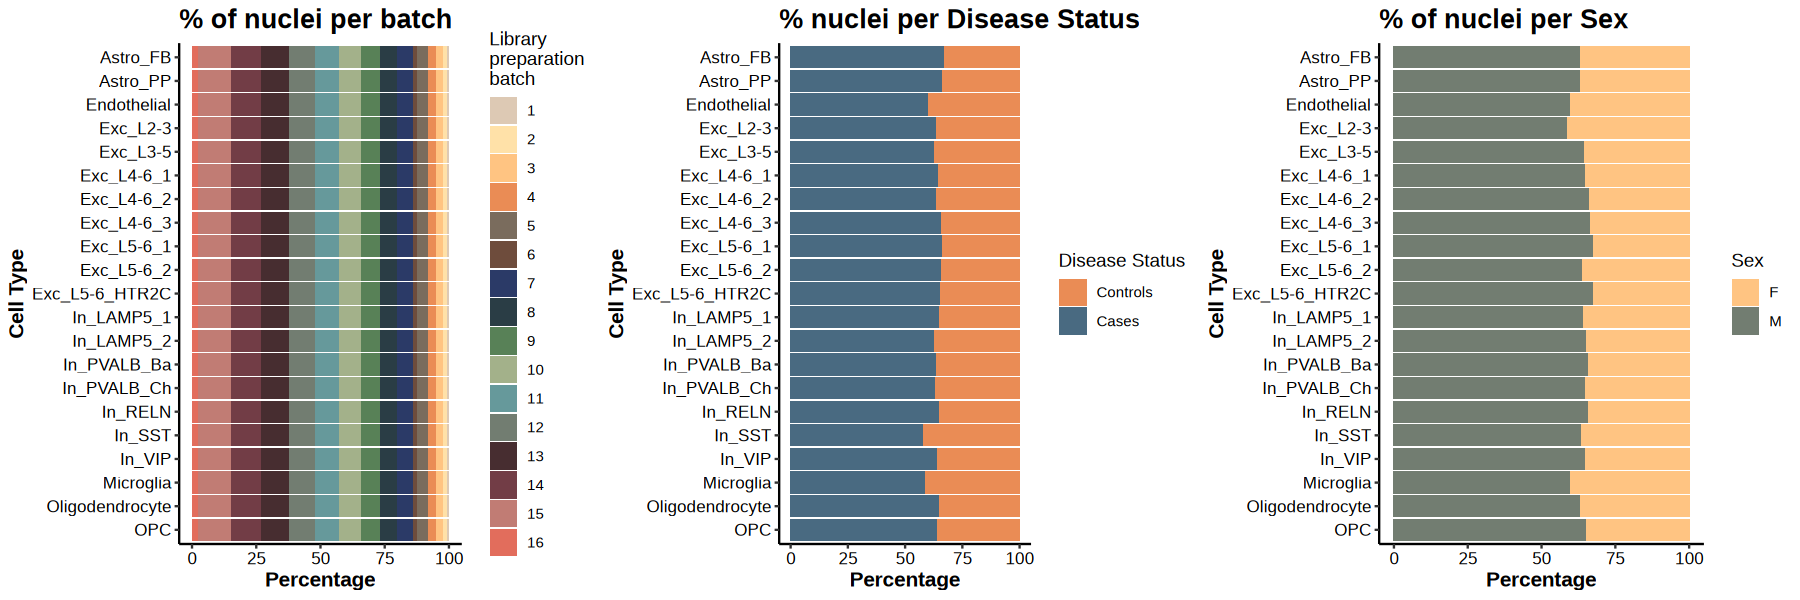

In [15]:
options(repr.plot.width=15, repr.plot.height=5)
plot_grid(plotlist=barplot_list, nrow=1)

In [18]:
ggsave(filename='../results/cohort_descrip/figures/stacked_percentage_nuclei_perBatch.pdf',plot=barplot_list[['batch']], width = 5, height = 5)
ggsave(filename='../results/cohort_descrip/figures/stacked_percentage_nuclei_perDiseaseStatus.pdf',plot=barplot_list[['Disease_Status']], width = 4.5, height = 5)
ggsave(filename='../results/cohort_descrip/figures/stacked_percentage_nuclei_perSex.pdf',plot=barplot_list[['Sex']], width = 4, height = 5)

## Extended Data Figure 2d

In [28]:
# % nuclei per individual
nuclei_per_celltype_per_individual <- as.data.frame(matrix(ncol=4, nrow=0))
colnames(nuclei_per_celltype_per_individual) <- c('individual', 'nuclei count', 'celltype', 'Percentage')
for (celltype in colnames(nuclei_counts_per_individual)[2:22]){
  tmp <- nuclei_counts_w_meta_data[,names(nuclei_counts_w_meta_data) %in% c('individual', celltype)]
  colnames(tmp) <- c('individual', 'nuclei count')
  tmp$celltype <- celltype
  tmp$Percentage <- tmp$`nuclei count`/sum(tmp$`nuclei count`, na.rm = T)*100
  nuclei_per_celltype_per_individual <- rbind(nuclei_per_celltype_per_individual, tmp)
}

nuclei_per_celltype_per_individual$celltype <- factor(nuclei_per_celltype_per_individual$celltype, 
                                                                  levels=c( "OPC", "Oligodendrocyte", "Microglia", "In_VIP", "In_SST", "In_RELN", "In_PVALB_Ch", "In_PVALB_Ba", "In_LAMP5_2", "In_LAMP5_1",  "Exc_L5-6_HTR2C", "Exc_L5-6_2", "Exc_L5-6_1", "Exc_L4-6_3", "Exc_L4-6_2", "Exc_L4-6_1",  "Exc_L3-5", "Exc_L2-3","Endothelial","Astro_PP","Astro_FB" ))

#make anonymous donor label
anonymous_label <- c()
for (i in c(1:87)){
    tmp <- paste0('s', i)
    anonymous_label <- c(anonymous_label, tmp) }

nuclei_per_celltype_per_individual$Donor <- as.character(anonymous_label)
nuclei_per_celltype_per_individual$Donor <- factor(nuclei_per_celltype_per_individual$Donor, 
                                                   levels=anonymous_label)

In [30]:
anonymous_donor_label <- nuclei_per_celltype_per_individual[nuclei_per_celltype_per_individual$celltype=='Exc_L2-3',] %>% select(c('individual', 'Donor'))
dim(anonymous_donor_label)
library(writexl)
write_xlsx(anonymous_donor_label, '../datasets/anonymous_donor_label.xlsx', col_names=T)

[1] 87  2

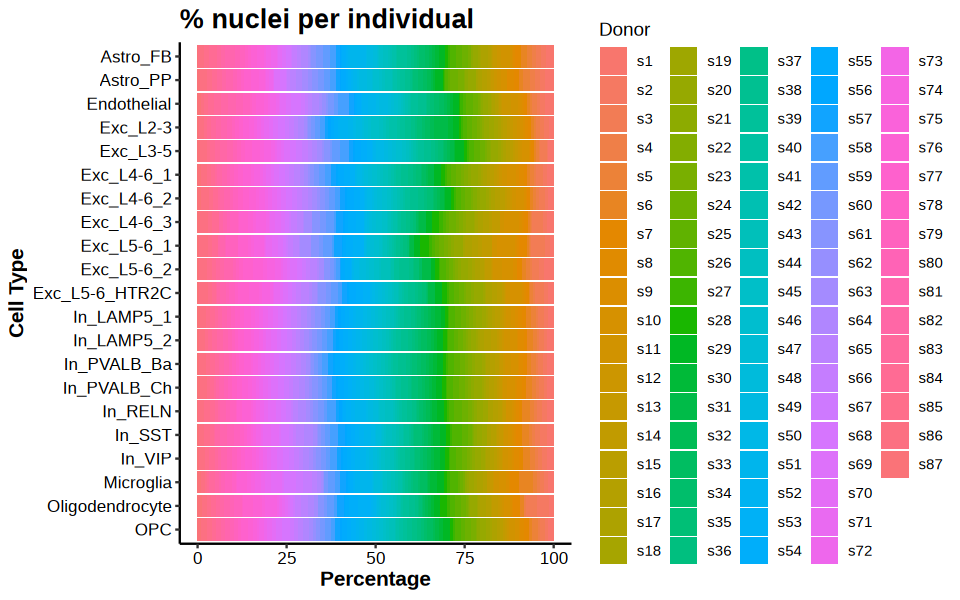

In [31]:
options(repr.plot.width=8, repr.plot.height=5)
ggplot(data=nuclei_per_celltype_per_individual, aes(x=celltype, y=Percentage,fill=Donor)) + 
  geom_bar(position = 'stack', stat='identity') + xlab('Cell Type') +ylab('Percentage') +
  coord_flip() + ylim(0,100) + ggtitle('% nuclei per individual') + theme_classic() + 
theme(axis.text=element_text(size=10, color = 'black'),  axis.title=element_text(size=12,face="bold"), plot.title = element_text(size=16, face='bold')) 

ggsave(filename='../results/cohort_descrip/figures/stacked_percentage_nuclei_perindividual.pdf',last_plot(), width = 8, height = 5)

# Supplementary Table 3 - Comparison number of nuclei between Controls and Cases

In [6]:
# select columns of interest
celltypes <- c( "OPC", "Oligodendrocyte", "Microglia", "In_VIP", "In_SST", "In_RELN", "In_PVALB_Ch", "In_PVALB_Ba", "In_LAMP5_2", "In_LAMP5_1",  "Exc_L5-6_HTR2C", "Exc_L5-6_2", "Exc_L5-6_1", "Exc_L4-6_3", "Exc_L4-6_2", "Exc_L4-6_1",  "Exc_L3-5", "Exc_L2-3","Endothelial","Astro_PP","Astro_FB" )
meta_data_subset <- nuclei_counts_w_meta_data[, c(celltypes,'individual' ,'Age', 'Disease_Status')]

#replace all 0 with NA (in the nuclei counts)
meta_data_subset[meta_data_subset == 0] <- NA

nuclei_counts_long <- meta_data_subset %>%
  pivot_longer(-c(individual, Disease_Status, Age), names_to = "Cell Type", values_to = "counts")


# check if counts are normally distributed
celltypes_not_normally_distributed <- c() 

counts_ctrls <- meta_data_subset[meta_data_subset$Disease_Status=='Controls', ]
counts_cases <- meta_data_subset[meta_data_subset$Disease_Status=='Cases', ]
for (celltype in celltypes){
    if (shapiro.test(counts_cases[, celltype])$p.value < 0.05){
        celltypes_not_normally_distributed <- c(celltypes_not_normally_distributed, celltype)
    }
    if (shapiro.test(counts_ctrls[, celltype])$p.value < 0.05){
        celltypes_not_normally_distributed <- c(celltypes_not_normally_distributed, celltype)
    }
}
celltypes_not_normally_distributed <- unique(celltypes_not_normally_distributed)

celltypes_normally_distributed <-  celltypes[!celltypes %in% celltypes_not_normally_distributed]


In [7]:
# test for equal variance in normally distributed data:
#In_SST unequal variance;  var.equal = FALSE

norm_unequal <- c()
for (celltype in celltypes_normally_distributed) {
  tmp <- meta_data_subset[, c('individual', 'Disease_Status', celltype)]
  colnames(tmp) <- c('individual', 'Disease_Status', 'celltype')
  res <- var.test(celltype ~ Disease_Status, data = tmp)
    if (res$p.value < 0.05){
        norm_unequal <- c(norm_unequal, celltype)
    }
}

norm_unequal

[1] "In_SST"

In [8]:
# test for equal variance in non-normally distributed data:
# Levene's test with one independent variable or fligner.test

not_norm_unequal <- c()
for (celltype in celltypes_not_normally_distributed){
    #subset dataframe for current_celltype
    tmp <- meta_data_subset[, c('Disease_Status', celltype)]
    colnames(tmp)[2] <- 'current_celltype'
    if (fligner.test(current_celltype ~ Disease_Status, data = tmp)$p.value < 0.05){
        not_norm_unequal <- c(not_norm_unequal, celltype)}
}
not_norm_unequal

[1] "Astro_FB"

In [9]:
# celltypes normally distributed with equal variance
norm_equal <-  celltypes_normally_distributed[!celltypes_normally_distributed %in% norm_unequal]

# Run multiple t-tests for celltypes with normal distribution and equal variance
norm_equal_var <- filter(nuclei_counts_long, `Cell Type`%in% norm_equal)

stat.test_norm_equal_var <- norm_equal_var %>%
  group_by(`Cell Type`) %>%
  t_test(counts ~ Disease_Status, var.equal = T, alternative = 'two.sided')

test_statistic_norm_equal <- as.data.frame(stat.test_norm_equal_var)
test_statistic_norm_equal$test <- 't-test'
test_statistic_norm_equal$variance <- 'equal'

# Run multiple t-tests for celltypes with normal distribution and unequal variance
norm_unequal_var <- filter(nuclei_counts_long, `Cell Type`%in% norm_unequal)

stat.test_norm_unequal_var <- norm_unequal_var %>%
  group_by(`Cell Type`) %>%
  t_test(counts ~ Disease_Status, var.equal = F, alternative = 'two.sided')

test_statistic_norm_unequal <- as.data.frame(stat.test_norm_unequal_var)
test_statistic_norm_unequal$test <- 't-test'
test_statistic_norm_unequal$variance <- 'unequal'

In [10]:
# Run multiple wilcox-tests for non-normally distributed data with equal variance
not_norm_equal <- celltypes_not_normally_distributed[!celltypes_not_normally_distributed %in% not_norm_unequal]
not_norm_equal_var <- filter(nuclei_counts_long, `Cell Type`%in% not_norm_equal)

stat.test_not_norm_equal_var <- as.data.frame(not_norm_equal_var %>%
                                                  group_by(`Cell Type`) %>%
                                                  wilcox_test(counts ~ Disease_Status, alternative = 'two.sided')) 

test_statistic_not_norm_equal <- stat.test_not_norm_equal_var
test_statistic_not_norm_equal$test <- 'wilcox'
test_statistic_not_norm_equal$variance <- 'equal'
test_statistic_not_norm_equal$df <- NA
test_statistic_not_norm_equal <- test_statistic_not_norm_equal[,c(1,2,3,4,5,6,7,8,11,9,10)]

In [11]:
# Run Brunner-Munzel test for non-normally distributed data with unequal variance
# The generalized Wilcoxon test should be applied when it cannot be assumed that variances are equal and 
# that the distribution is symmetric.
# generalized Wilcoxon test: Brunner-Munzel test

not_norm_unequal_var <- filter(nuclei_counts_long, `Cell Type`%in% not_norm_unequal)

#brunner.munzel.test:
# x: the numeric vector of data values from the sample 1.
# y:the numeric vector of data values from the sample 2.
test_statistic_not_norm_unequal <- as.data.frame(matrix(ncol=11, nrow=0))
colnames(test_statistic_not_norm_unequal) <- c('Cell Type', '.y.', 'group1', 'group2', 'n1', 'n2', 'statistic', 'p', 'df', 'test', 'variance')
for (celltype in not_norm_unequal){
    tmp_controls <- not_norm_unequal_var[not_norm_unequal_var$`Cell Type` == celltype & not_norm_unequal_var$Disease_Status=='Controls',]
    tmp_cases <- not_norm_unequal_var[not_norm_unequal_var$`Cell Type` == celltype & not_norm_unequal_var$Disease_Status=='Cases',]
    tmp <- brunner.munzel.test(tmp_controls$counts, tmp_cases$counts, alternative = 'two.sided',  alpha = 0.05)
    test_stat <- as.data.frame(matrix(ncol=11, nrow=1))
    colnames(test_stat) <- c('Cell Type', '.y.', 'group1', 'group2', 'n1', 'n2', 'statistic', 'p', 'df', 'test', 'variance')
    test_stat$`Cell Type` <- celltype
    test_stat$`.y.` <- 'counts'
    test_stat$group1 <- 'Controls'
    test_stat$group2 <- 'Cases'
    test_stat$n1 <- length(tmp_controls$counts)
    test_stat$n2 <- length(tmp_cases$counts)
    test_stat$statistic <- tmp$statistic
    test_stat$p <- tmp$p.value
    test_stat$df <- tmp$parameter
    test_stat$test <- 'brunner-munzel test'
    test_stat$variance <- 'unequal'
    test_statistic_not_norm_unequal <- rbind(test_statistic_not_norm_unequal, test_stat) 
}
#test_statistic_not_norm_unequal

In [12]:
full_test_statistic <- rbind(test_statistic_norm_equal, test_statistic_norm_unequal, 
                             test_statistic_not_norm_equal, test_statistic_not_norm_unequal)
full_test_statistic$`.y.` <- NULL
colnames(full_test_statistic)[which(names(full_test_statistic) == 'p')] <- 'p-value'

full_test_statistic <- full_test_statistic[order(full_test_statistic$`Cell Type`),]
full_test_statistic

,Cell Type,group1,group2,n1,n2,statistic,df,p-value,test,variance
,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
21,Astro_FB,Controls,Cases,33,54,1.1243543,84.56199,0.2640443,brunner-munzel test,unequal
1,Astro_PP,Controls,Cases,33,54,-1.4215569,85.00000,0.1590000,t-test,equal
11,Endothelial,Controls,Cases,33,54,954.0000000,NA,0.5850000,wilcox,equal
12,Exc_L2-3,Controls,Cases,33,54,872.0000000,NA,0.8710000,wilcox,equal
13,Exc_L3-5,Controls,Cases,33,54,871.0000000,NA,0.8650000,wilcox,equal
2,Exc_L4-6_1,Controls,Cases,33,54,-0.8714615,85.00000,0.3860000,t-test,equal
3,Exc_L4-6_2,Controls,Cases,33,54,-0.6677093,85.00000,0.5060000,t-test,equal
14,Exc_L4-6_3,Controls,Cases,33,52,682.5000000,NA,0.1150000,wilcox,equal
15,Exc_L5-6_1,Controls,Cases,33,53,751.0000000,NA,0.2750000,wilcox,equal


In [13]:
library(writexl)
write_xlsx(full_test_statistic, '../results/cohort_descrip/tables/stat_n_nuclei_controls_vs_cases.xlsx', col_names=T)

# SessionInfo

In [14]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /psycl/u/afroe/conda-envs/dreamlet_duplicated/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Berlin
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] writexl_1.4.2   lawstat_3.6     rstatix_0.7.2   car_3.1-2      
 [5] carData_3.0-5   ggpubr_0.6.0    cowplot_1.1.1   readxl_1.4.3   
 [9] lubridate_1.9.3 forcats_1.0.0   stringr_1.5.0   dplyr_1.1.3    
[13]